In [5]:
import tarfile

# Extract 'train-clean-100.tar.gz'
with tarfile.open('/scratchSSD2/databaseTFM/train-clean-100.tar.gz', 'r:gz') as tar:
    tar.extractall('/scratchSSD2/databaseTFM/LibriSpeech/dev-clean')

Functions for adding noise and segmenting

In [6]:
import librosa
import numpy as np
import os
import math

SAMPLE_RATE = 16000

def add_noise(audio) : 
    P_signal = audio.std()**2    # Power of the signal
    SNR_dB = np.random.uniform(-5,15)
    P_noise = P_signal * 10**(-SNR_dB / 10)
    noise = np.sqrt(P_noise) * np.random.randn(len(audio))

    n_audio = audio + noise

    n_audio = np.clip(n_audio, -2**15, 2**15 - 1)  # for 16-bit PCM audio

    
    return n_audio  


def split_or_pad_audio(file_path, segment_duration=5000):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # Calculate the number of 5-second segments
    samples_duration = int((segment_duration/1000)*SAMPLE_RATE)
    num_segments = math.ceil(len(audio)/samples_duration)
    
    segments = []
    for i in range(num_segments):
        start = i * samples_duration
        end = start + samples_duration
        segment = audio[start:end]
        
        if len(segment) < samples_duration:
            padding = np.zeros(samples_duration - len(segment))
            segment = np.concatenate([segment, padding])
            
        segments.append((add_noise(segment),segment))

    return segments

In [ ]:
# Spliting Audios 5 seconds

import math
import os

# Gather audio file paths and transcriptions
audio_tuple = []
count = 0
max_files = 10000

for root, dirs1, files in os.walk("/scratchSSD2/databaseTFM/LibriSpeech/dev-clean"):
    for file in files:
        if file.endswith(".flac"):
            audio_path = os.path.join(root, file)
            segment_tuple = split_or_pad_audio(audio_path,5000)
            audio_tuple.extend(segment_tuple)
            count += 1
            if count >= max_files:
                break
    if count >= max_files:
        break


In [58]:
import librosa
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, audio_data):
        """
        Args:
            metadata_file (str): Path to the file with audio file paths and labels.
            transform (callable, optional): Optional transform to apply on a sample.
        """
        self.audio_data = audio_data  

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        
        noisy_audio, clean_audio = self.audio_data[idx]
        # Load audio and calculate spectrogram from clean and noisy audio
        S_noisy = librosa.stft(noisy_audio, n_fft=512, hop_length=160, win_length=400)
        S_dB_noisy = librosa.amplitude_to_db(np.abs(S_noisy), ref=np.max)

        S_clean = librosa.stft(clean_audio, n_fft=512, hop_length=160, win_length=400)
        S_dB_clean = librosa.amplitude_to_db(np.abs(S_clean), ref=np.max)
        
        # Convert to tensor
        S_dB_noisy = torch.tensor(S_dB_noisy, dtype=torch.float32)
        S_dB_clean = torch.tensor(S_dB_clean, dtype=torch.float32)
        
        return S_dB_noisy, S_dB_clean

In [ ]:
from torch.utils.data import DataLoader

audio_dataset = AudioDataset(audio_tuple)
audio_dataloader = DataLoader(audio_dataset, batch_size=32, shuffle=True)

# Iterate through the DataLoader
#for noisy_batch, clean_batch in audio_dataloader:
    #print(f"Noisy batch shape: {noisy_batch.shape}")
    #print(f"Clean batch shape: {clean_batch.shape}")
print(len(audio_dataloader))

98


Training


In [10]:
print(noisy_batch.transpose(1,2).shape)
LSTM = torch.nn.LSTM(257, 514, batch_first=True, bidirectional=False, num_layers=1)
linear1 = torch.nn.Linear(514, 257)

x, state = LSTM(noisy_batch.transpose(1,2))
print( x.shape, state[0].shape, state[1].shape )
out = linear1(x)
print( out.shape )

torch.Size([5, 501, 257])


torch.Size([5, 501, 514]) torch.Size([1, 5, 514]) torch.Size([1, 5, 514])
torch.Size([5, 501, 257])


In [60]:
class Net1(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size, bidir=False, n_lstm_layers=1):
    super().__init__()
    #self.linear1 = torch.nn.Linear(128, 2)
    self.LSTM = torch.nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=bidir, num_layers=n_lstm_layers)
    self.drop = torch.nn.Dropout(0.25)
    self.linear1 = torch.nn.Linear(hidden_size*2, output_size)
  def forward(self, x):
    x, _ = self.LSTM(x)
    #x = self.drop(x)
    x = self.linear1(x)
    return x

  def predict(self, x):
    with torch.no_grad():
      x = self.forward(x)
      return torch.argmax(x, dim=1)

  def predict_proba(self, x):
    with torch.no_grad():
      x = self.forward(x)
      return torch.softmax(x, dim=1)

In [61]:
import matplotlib.pyplot as plt

def train_model(model, dataloader, num_epochs=10, learning_rate=0.001):
    """
    Train the LSTM model.
    
    Args:
        model (nn.Module): The LSTM model to train.
        dataloader (DataLoader): DataLoader for training data.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
    """

    J = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    J_it = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        #model.train()  # Set the model to training model
        k = 0
        for noisy_audio, clean_audio in dataloader:
            
            noisy_audio = noisy_audio.transpose(1, 2).to(device)  # LSTM expects (batch, seq_len, input_size)
            clean_audio = clean_audio.transpose(1, 2).to(device)

            # Normalization
            noisy_audio = (noisy_audio - noisy_audio.mean()) / noisy_audio.std()
            clean_audio = (clean_audio - clean_audio.mean()) / clean_audio.std()

            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(noisy_audio)
            
            # Compute the loss (MSE loss between predicted and clean spectrogram)
            loss = J(output, clean_audio)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            J_it[epoch] += loss.item()
            k += 1
        
        # Print the average loss for this epoch
        J_it[epoch] /= k
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {J_it[epoch]:.4f}")

    print("Training complete.")
    print(k)
    plt.clf()
    plt.plot(J_it,'b', markersize=8, linestyle='-', marker='.')
    plt.ylabel('J')
    plt.xlabel('it')
    plt.grid(True)


Using device: cuda


Epoch 1/20, Loss: 0.4195
Epoch 2/20, Loss: 0.3052
Epoch 3/20, Loss: 0.2954
Epoch 4/20, Loss: 0.2657
Epoch 5/20, Loss: 0.2482
Epoch 6/20, Loss: 0.2429
Epoch 7/20, Loss: 0.2272
Epoch 8/20, Loss: 0.2213
Epoch 9/20, Loss: 0.2123
Epoch 10/20, Loss: 0.2027
Epoch 11/20, Loss: 0.2045
Epoch 12/20, Loss: 0.1925
Epoch 13/20, Loss: 0.1848
Epoch 14/20, Loss: 0.1797
Epoch 15/20, Loss: 0.1776
Epoch 16/20, Loss: 0.1693
Epoch 17/20, Loss: 0.1676
Epoch 18/20, Loss: 0.1671
Epoch 19/20, Loss: 0.1583
Epoch 20/20, Loss: 0.1559
Training complete.
98


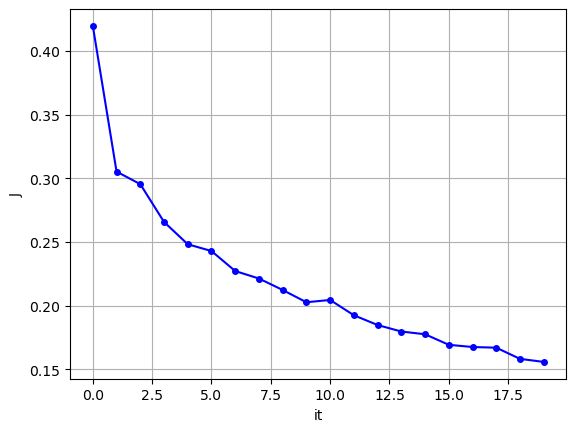

In [62]:
# Define model parameters
input_size = 257  # For example, number of frequency bins in STFT (assuming 512 FFT size, 257 bins for half)
hidden_size = 512  # Hidden layer size
output_size = 257  # Output has the same size as input spectrogram (257 bins)
num_epochs = 20
learning_rate = 0.001
bidir_lstm = True
num_lstm_layers = 3

#Selecting cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model
model = Net1(input_size, hidden_size, output_size, bidir_lstm, num_lstm_layers)

# Train the model
train_model(model.to(device), audio_dataloader, num_epochs=num_epochs, learning_rate=learning_rate)


TESTING PHASE

In [ ]:
!wget https://www.openslr.org/resources/12/test-clean.tar.gz -O /scratchSSD2/databaseTFM/test-clean.tar.gz

In [51]:
import tarfile

# Extract 'test-clean-100.tar.gz'
with tarfile.open('/scratchSSD2/databaseTFM/test-clean.tar.gz', 'r:gz') as tar:
    tar.extractall('/scratchSSD2/databaseTFM/LibriSpeech/test-clean')

In [54]:
# Spliting Audios 5 seconds

import math
import os

# Gather audio file paths and transcriptions
test_audio_tuple = []

for root, dirs1, files in os.walk("/scratchSSD2/databaseTFM/LibriSpeech/test-clean"):
    for file in files:
        if file.endswith(".flac"):
            test_audio_path = os.path.join(root, file)
            segment_tuple = split_or_pad_audio(audio_path,5000)
            test_audio_tuple.extend(segment_tuple)
            

In [56]:
from torch.utils.data import DataLoader

test_audio_dataset = AudioDataset(test_audio_tuple)
test_audio_dataloader = DataLoader(test_audio_dataset, batch_size=32)

# Iterate through the DataLoader
#for noisy_batch, clean_batch in audio_dataloader:
    #print(f"Noisy batch shape: {noisy_batch.shape}")
    #print(f"Clean batch shape: {clean_batch.shape}")
print(len(test_audio_dataloader))

246
